In [1]:
import numpy as np
import seaborn as sns

from scipy.stats import norm
from time import time

# Introduction example

The code below simulates the example in the introduction, but also computes the adaptive estimator with constant allocation (LvdL) weights.

In [2]:
np.random.seed(1234)
begin_time = time()

In [3]:
# Experiment length
T = 10_000 

# Number of arms
K = 2

# Number of replications
num_sims = 20_000

In [4]:
sample_mean = np.empty((num_sims, K), dtype=float)
aw_estimate = np.empty((num_sims, K), dtype=float)
ipw_estimate = np.empty((num_sims, K), dtype=float)

sample_mean_student = np.empty((num_sims, K), dtype=float)
aw_student = np.empty((num_sims, K), dtype=float)
ipw_student = np.empty((num_sims, K), dtype=float)

for s in range(num_sims):
    if s % 1000 == 0:
        print(f'Simulation {s}')

    potential_outcomes = np.random.normal(loc=0, scale=1, size=(T, 2))

    # Initialize vectors to store data
    outcomes = np.empty(T, dtype=float)
    arms = np.empty(T, dtype=int)
    propensity = np.empty((T, K), dtype=float)

    # First half of simulation
    arms[:T//2] = np.random.choice([0, 1], p=[.5, .5], size=T//2)
    outcomes[:T//2] = potential_outcomes[np.arange(T//2), arms[:T//2]]
    propensity[:T//2, :] = 1/2

    # Arm selection step
    means_first_half = np.empty(2)
    means_first_half[0] = np.mean(outcomes[:T//2][arms[:T//2] == 0])
    means_first_half[1] = np.mean(outcomes[:T//2][arms[:T//2] == 1])
    selected_arm = np.argmax(means_first_half)

    # Second half of simulation
    if selected_arm == 0:
        probs = np.array([.9, .1])
    else:
        probs = np.array([.1, .9])
    arms[T//2:] = np.random.choice([0, 1], p=probs, size=T//2)
    outcomes[T//2:] = potential_outcomes[np.arange(T//2, T), arms[T//2:]]
    propensity[T//2:, :] = probs

    # --- Sample mean estimates ----
    muhat = np.empty(2)
    muhat[0] = np.mean(outcomes[arms == 0])
    muhat[1] = np.mean(outcomes[arms == 1])
    
    n = np.empty(2)
    n[0] = np.sum(arms == 0)
    n[1] = np.sum(arms == 1)
    
    std = np.empty(2)
    std[0] = np.std(outcomes[arms == 0])
    std[1] = np.std(outcomes[arms == 1])
    
    sample_mean[s] = muhat
    sample_mean_student[s] = np.sqrt(n) * muhat / std
    
    # --- IPW estimates -----
    e = propensity[np.arange(T), arms]
    scores = np.zeros((T, K))
    scores[np.arange(T), arms] += 1/e * outcomes
    
    ipw_estimate[s, :] = scores.mean(0)
    ipw_student[s, :] = np.sqrt(T) * scores.mean(0) / scores.std(0)
    
    
    # --- Adaptively-weighted estimator -----
    # aipw scores
    e = propensity[np.arange(T), arms]
    scores = np.empty((T, K))
    scores[:] = muhat
    scores[np.arange(T), arms] += 1/e * (outcomes - muhat[arms])

    # allocation rates
    tt = np.arange(T)
    lambda_alloc = 1 / (T - tt + 1) 
    
    # evaluation weights
    h2e = np.zeros((T, K))  # h^2/e
    h2e_sum = np.zeros(K)
    for t in range(T):
        h2e[t, :] = lambda_alloc[t] * (1 - h2e_sum)
        h2e_sum += h2e[t, :]
    evaluation_weights = np.sqrt(np.maximum(0., h2e * propensity))
        
    # statistics
    estimate = np.sum(evaluation_weights * scores, 0)  / np.sum(evaluation_weights, 0)
    se = np.sqrt(np.sum(evaluation_weights ** 2 * (scores - estimate)** 2, 0)) / np.sum(evaluation_weights, 0)
    
    aw_estimate[s] = estimate
    aw_student[s] = estimate / se
    

Simulation 0
Simulation 1000
Simulation 2000
Simulation 3000
Simulation 4000
Simulation 5000
Simulation 6000
Simulation 7000
Simulation 8000
Simulation 9000
Simulation 10000
Simulation 11000
Simulation 12000
Simulation 13000
Simulation 14000
Simulation 15000
Simulation 16000
Simulation 17000
Simulation 18000
Simulation 19000


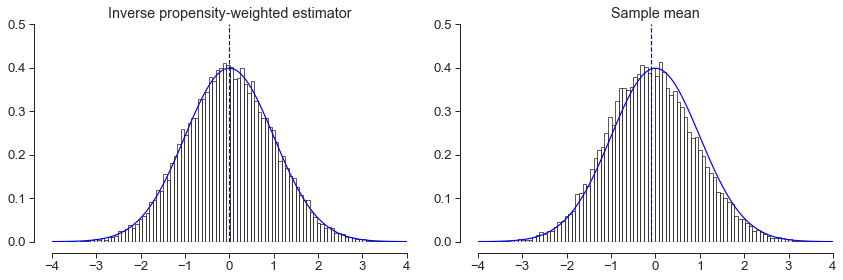

In [13]:
sns.set(style='ticks')
sns.set_context('paper', font_scale=1.5)

xs = np.linspace(-4, 4, 100)

bins = 100
fig, axs = plt.subplots(1, 2, figsize=(14, 4),  dpi=72, facecolor="white")

axs[0].hist(aw_student[:, 0], bins=bins, density=True, alpha=.8, facecolor='white', edgecolor='black');
axs[0].plot(xs, norm.pdf(xs), color='blue', linestyle='-')
axs[0].axvline(np.mean(aw_student[:, 0]), color="blue", linestyle="--")
axs[0].set_title('Inverse propensity-weighted estimator')

axs[1].hist(sample_mean_student[:,0], bins=bins, density=True, alpha=.8, facecolor='white', edgecolor='black');
axs[1].plot(xs, norm.pdf(xs), color='blue', linestyle='-')
axs[1].axvline(np.mean(sample_mean_student[:, 0]), color="blue", linestyle="--")
axs[1].set_title('Sample mean')

# Tricks for base-r like plots
for ax in axs.flat:
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('axes', -0.05))
    ax.axhline(0, color='black')
    ax.set_xlim(-4, 4)
    ax.set_ylim(0, .5)

sns.despine()

fig.subplots_adjust()
fig.savefig('figures/intro_example.pdf')

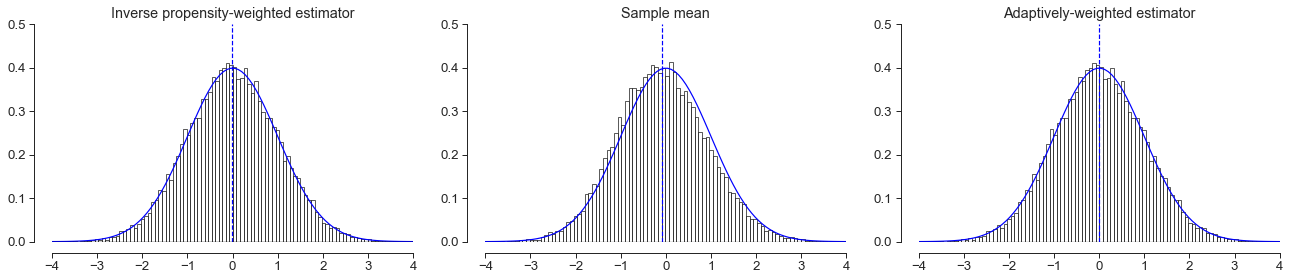

In [12]:
sns.set(style='ticks')
sns.set_context('paper', font_scale=1.5)

xs = np.linspace(-4, 4, 100)

bins = 100
fig, axs = plt.subplots(1, 3, figsize=(22, 4),  dpi=72, facecolor="white")

axs[0].hist(aw_student[:, 0], bins=bins, density=True, alpha=.8, facecolor='white', edgecolor='black');
axs[0].plot(xs, norm.pdf(xs), color='blue', linestyle='-')
axs[0].axvline(np.mean(aw_student[:, 0]), color="blue", linestyle="--")
axs[0].set_title('Inverse propensity-weighted estimator')

axs[0].spines['bottom'].set_position(('axes', -0.05))
axs[0].yaxis.set_ticks_position('left')
axs[0].spines['left'].set_position(('axes', -0.05))
axs[0].axhline(0, color='black')

axs[2].hist(aw_student[:, 0], bins=bins, density=True, alpha=.8, facecolor='white', edgecolor='black');
axs[2].plot(xs, norm.pdf(xs), color='blue', linestyle='-')
axs[2].axvline(np.mean(aw_student[:, 0]), color="blue", linestyle="--")
axs[2].set_title('Adaptively-weighted estimator')

axs[1].hist(sample_mean_student[:,0], bins=bins, density=True, alpha=.8, facecolor='white', edgecolor='black');
axs[1].plot(xs, norm.pdf(xs), color='blue', linestyle='-')
axs[1].axvline(np.mean(sample_mean_student[:, 0]), color="blue", linestyle="--")
axs[1].set_title('Sample mean')

# Tricks for base-r like plots
for ax in axs.flat:
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('axes', -0.05))
    ax.axhline(0, color='black')
    ax.set_xlim(-4, 4)
    ax.set_ylim(0, .5)
    
sns.despine()


fig.savefig('figures/intro_example_revisited.pdf')

In [9]:
end_time = time()
print("Total time: {:1.1f} seconds.".format(end_time - begin_time))

Total time: 1325.5 seconds.
